# Project: CAM 만들고 평가하기
- Class Activation Map(CAM)
- Grad-CAM

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

import os

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 로드

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

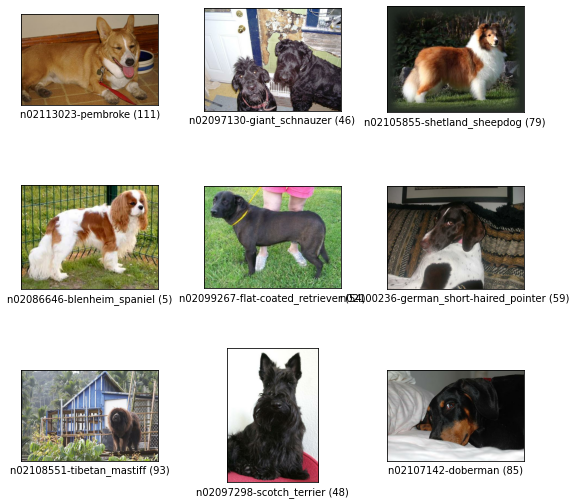

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

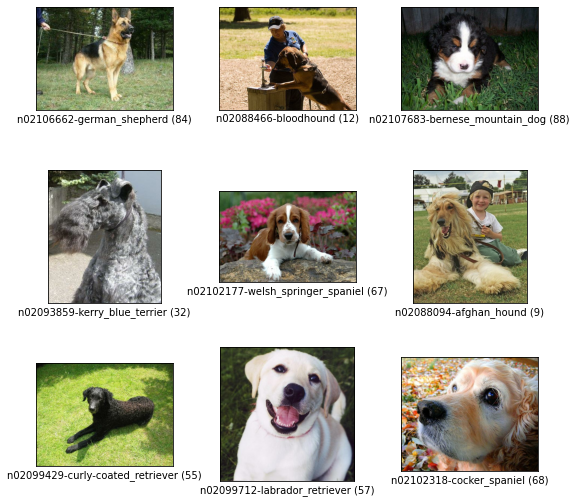

In [4]:
_ = tfds.show_examples(ds_test, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## 2. 모델 준비

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation="softmax")(x)

cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [10]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [11]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 167s 212ms/step - loss: 2.3041 - accuracy: 0.4231 - val_loss: 3.2371 - val_accuracy: 0.2281
Epoch 2/10
750/750 [==============================] - 158s 210ms/step - loss: 0.6495 - accuracy: 0.8253 - val_loss: 1.1172 - val_accuracy: 0.6706
Epoch 3/10
750/750 [==============================] - 158s 211ms/step - loss: 0.1807 - accuracy: 0.9707 - val_loss: 1.0740 - val_accuracy: 0.6895
Epoch 4/10
750/750 [==============================] - 157s 210ms/step - loss: 0.0598 - accuracy: 0.9971 - val_loss: 1.0007 - val_accuracy: 0.7130
Epoch 5/10
750/750 [==============================] - 158s 210ms/step - loss: 0.0302 - accuracy: 0.9985 - val_loss: 0.9763 - val_accuracy: 0.7233
Epoch 6/10
750/750 [==============================] - 157s 210ms/step - loss: 0.0204 - accuracy: 0.9993 - val_loss: 0.9851 - val_accuracy: 0.7266
Epoch 7/10
750/750 [==============================] - 157s 210ms/step - loss: 0.0147 - accuracy: 0.9994 - val_loss: 0.9835 -

In [12]:
# 모델 가중치 저장
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("Model Saved")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model Saved


## 3. CAM

In [13]:
# CAM 생성 작업은 배치 단위가 아닌 개별 이미지 데이터 단위로 이루어지기 때문에 한 장씩 뽑음
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

46


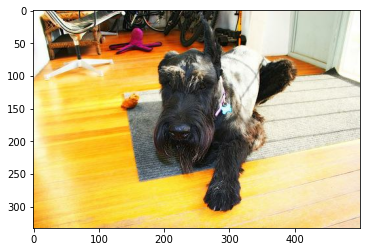

In [14]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [15]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있음
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타남
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

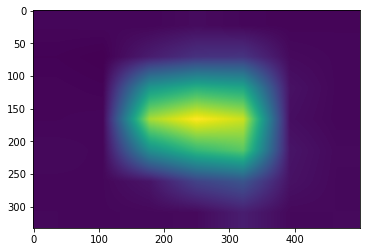

In [16]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [17]:
# 원본 이미지와 합치기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

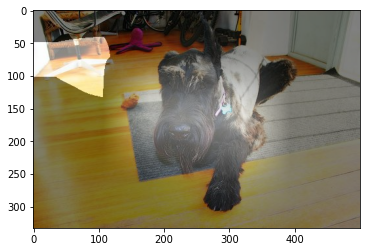

In [18]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 4. Grad-CAM

In [19]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻음
        output = conv_output[0] # 원하는 layer의 output을 얻음
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻음

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻음
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

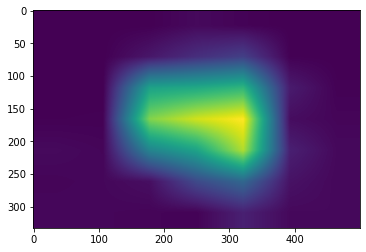

In [20]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

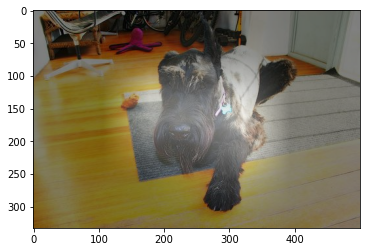

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

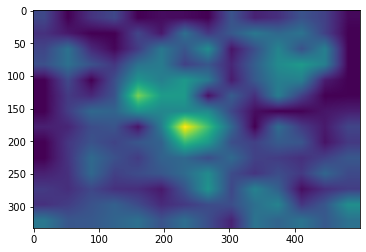

In [22]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image2)
plt.show()

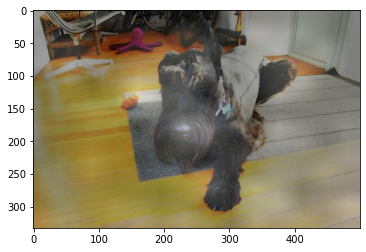

In [23]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image2*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

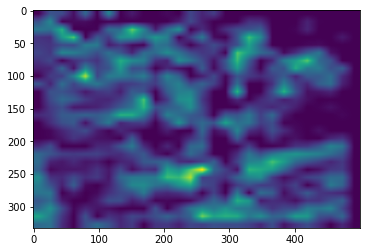

In [24]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

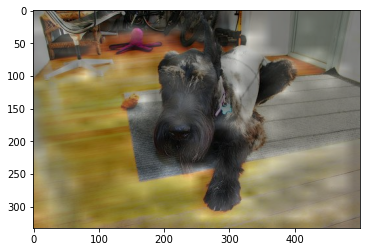

In [25]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 5. Bounding Box 구하기

In [26]:
# score_thresh 이하의 bbox는 없앤다.
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [27]:
# 데이터에 제공된 bbox 좌표 구하기
y1 = int(item['image'].shape[0] * item['objects']['bbox'][0][0])
y2 = int(item['image'].shape[0] * item['objects']['bbox'][0][2])
x1 = int(item['image'].shape[1] * item['objects']['bbox'][0][1])
x2 = int(item['image'].shape[1] * item['objects']['bbox'][0][3])
rect_origin = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])
rect_origin

array([[180,  51],
       [402,  51],
       [402, 308],
       [180, 308]])

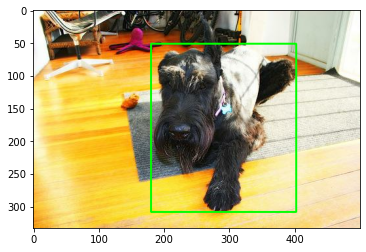

In [28]:
origin_image = item['image'].astype(np.uint8)
origin_image = cv2.drawContours(origin_image, [rect_origin], 0, (0,255,0), 2)

plt.imshow(origin_image)
plt.show()

In [29]:
rect_cam = get_bbox(cam_image)
rect_cam

array([[111,  39],
       [391,  39],
       [391, 332],
       [111, 332]])

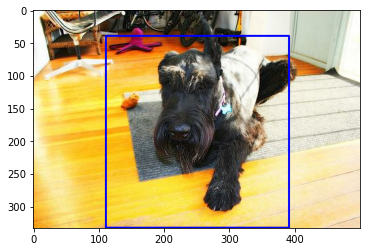

In [30]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [31]:
rect_gc = get_bbox(grad_cam_image)
rect_gc

array([[111,  35],
       [433,  35],
       [433, 332],
       [111, 332]])

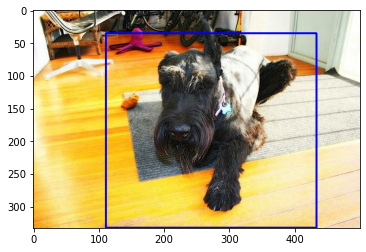

In [32]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_gc], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 6. IoU 구하기

In [33]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [34]:
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
pred_bbox_cam

[0.11711711711711711, 0.222, 0.996996996996997, 0.782]

In [35]:
pred_bbox_gc = rect_to_minmax(rect_gc, item['image'])
pred_bbox_gc

[0.10510510510510511, 0.222, 0.996996996996997, 0.866]

In [36]:
item['objects']['bbox']

array([[0.15615615, 0.36      , 0.9279279 , 0.804     ]], dtype=float32)

In [37]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [38]:
get_iou(pred_bbox_cam, item['objects']['bbox'][0])

0.6389644610102009

In [39]:
get_iou(pred_bbox_gc, item["objects"]["bbox"][0])

0.5965870208217895

## 7. CAM vs. Grad-CAM 성능 비교

### 1) 원본 이미지 합성 비교

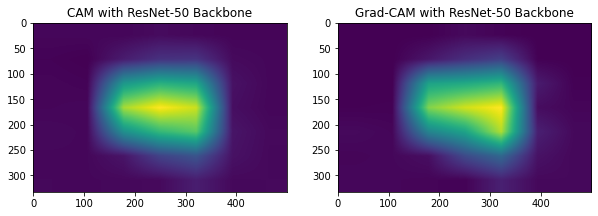

In [40]:
# CAM
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title("CAM with ResNet-50 Backbone")
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

plt.subplot(1, 2, 2)
plt.title("Grad-CAM with ResNet-50 Backbone")
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

plt.show()

 CAM이 좀 더 넓은 영역을 본 것을 확인할 수 있다.

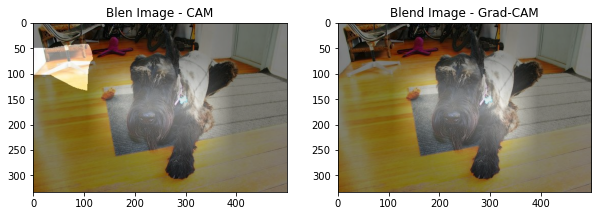

In [41]:
origin_image = item['image'].astype(np.uint8)

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Blen Image - CAM")
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

plt.subplot(1, 2, 2)
plt.title("Blend Image - Grad-CAM")
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image_gc = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_gc)

plt.show()

CAM과 Grad-CAM 모두 개의 주요 특징 위치를 잘 반영한 것을 확인할 수 있다. <br>
하지만 CAM이 강아지의 몸통/얼굴 부위를 좀 더 반영한 것 같다.(합성 결과 그 부위가 좀 더 하얀 것을 확인할 수 있음)

### 2) 바운딩 박스 비교

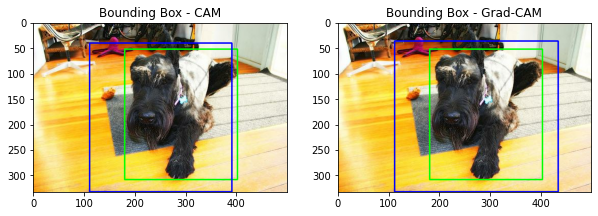

In [42]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Bounding Box - CAM")
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_origin], 0, (0,255,0), 2)
image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Bounding Box - Grad-CAM")
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_origin], 0, (0,255,0), 2)
image = cv2.drawContours(image, [rect_gc], 0, (0,0,255), 2)
plt.imshow(image)

plt.show()

CAM, Grad-CAM 모두 개의 위치를 잘 찾았다. <br>
CAM의 bbox가 조금 더 좁은 영역을 잡아낸 것을 확인할 수 있다.

### 3) IoU 비교

In [43]:
iou_cam = get_iou(pred_bbox_cam, item['objects']['bbox'][0])
iou_gc = get_iou(pred_bbox_gc, item["objects"]["bbox"][0])

In [44]:
print(f"CAM IoU Score: {iou_cam:.4f}")
print(f"Grad-CAM IoU Score: {iou_gc:.4f}")

CAM IoU Score: 0.6390
Grad-CAM IoU Score: 0.5966


CAM의 IoU score가 Grad-CAM보다 조금 더 높은 것을 확인할 수 있다.

## 회고

- 딥러닝 모델이 태스크를 수행하는 과정에서 어디에 더 집중하였는지에 대해 설명력을 부여하는 CAM에 대해 알아볼 수 있었다.
- Grad-CAM은 꼭 마지막 레이어가 아니어도 값을 가져와서 CAM을 시각화할 수 있었는데, 그래도 마지막 레이어가 제일 설명력이 높은 것을 확인할 수 있었다.
- 앞단으로 갈수록 랜덤하게 여기 저기 본 것 같다는 느낌이 들었다.
- bounding box를 그려봤을 때 CAM과 Grad-CAM 모두 개의 위치를 잘 찾아낸 것을 확인할 수 있었다.
- IoU를 비교했을 때 CAM의 IoU score가 Grad-CAM보다 약 2.5% 더 높게 나왔다. Grad-CAM이 더 나을 것이라고 예상한 것과 조금 다른 결과가 나왔다.
- 이는 threshold 이상의 값들이 CAM에 더 많았기 때문이라고 생각한다. (class activation map을 그려봤을 때 노란색의 영역이 CAM이 Grad-CAM보다 더 넓었음)